In [1]:
import pandas as pd
import numpy as np 
from sklearn.preprocessing import QuantileTransformer
from sklearn.model_selection import train_test_split
from sklearn.metrics import precision_score, recall_score, f1_score, confusion_matrix, accuracy_score
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score
import time
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_curve, auc, precision_recall_curve, classification_report, confusion_matrix

from aeon.classification.convolution_based import Arsenal, RocketClassifier



In [2]:
file=r"C:\Users\chira\Desktop\IDS\SensorNetGuard A Dataset for Identifying Malicious Sensor Nodes.csv"
df= pd.read_csv(file)

df.head(5)

,Node_ID,Timestamp,IP_Address,Packet_Rate,Packet_Drop_Rate,Packet_Duplication_Rate,Data_Throughput,Signal_Strength,SNR,Battery_Level,...,Number_of_Neighbors,Route_Request_Frequency,Route_Reply_Frequency,Data_Transmission_Frequency,Data_Reception_Frequency,Error_Rate,CPU_Usage,Memory_Usage,Bandwidth,Is_Malicious
0,1,01-02-23 0:00,192.168.119.138,52.018229,2.727317,0.955687,130.967180,-52.059232,23.974265,82.982598,...,3,11.323044,11.458199,20.670539,14.385439,0.109146,26.376693,29.186341,76.811986,0
1,2,01-02-23 0:01,192.168.225.56,59.504648,1.435058,1.228460,82.634358,-57.754723,22.572052,66.734853,...,6,8.277362,8.832980,15.555122,14.316681,0.077136,34.963429,34.203177,112.495912,0
2,3,01-02-23 0:02,192.168.187.210,34.118204,1.320905,1.015245,61.649928,-52.399037,15.667076,74.593605,...,5,8.196374,8.330227,19.470748,11.792084,0.052993,48.934585,31.682662,117.526109,0
3,4,01-02-23 0:03,192.168.78.245,39.643055,1.988791,0.784562,69.704181,-53.727443,20.286962,76.710564,...,6,10.683766,6.525032,16.228955,8.895409,0.087810,47.045600,37.470027,123.058913,0
4,5,01-02-23 0:04,192.168.233.229,40.212679,1.005121,1.412193,123.445612,-49.696620,24.318538,84.477890,...,7,11.176823,10.617432,12.257423,10.168739,0.068823,33.394354,26.582970,71.696911,0


In [3]:
def preprocess_timeseries_data(df, timestamp_column):
    """
    Preprocesses the time series data by parsing timestamps, sorting, and setting the index.
    Extracts only day, hour, minute, and second features.
    
    Args:
    df (pd.DataFrame): The dataframe containing the timestamp column.
    timestamp_column (str): The name of the timestamp column to preprocess.
    
    Returns:
    pd.DataFrame: The dataframe with the timestamp column parsed, sorted, and set as the index,
                  with only day, hour, minute, and second features extracted.
    """
    
    # Ensure the timestamp column is in datetime format with the specified format
    df[timestamp_column] = pd.to_datetime(df[timestamp_column], format='%m-%d-%y %H:%M')
    
    # Sort the dataframe by the timestamp column
    df = df.sort_values(by=timestamp_column)
    
    # Set the timestamp column as the index
    df.set_index(timestamp_column, inplace=True)
    
    # Extract only day, hour, minute, and second features
    df['day'] = df.index.day
    df['hour'] = df.index.hour
    df['minute'] = df.index.minute
    df['second'] = df.index.second
    
    return df

def ip_to_int(ip):
    """Convert an IPv4 address to an integer."""
    parts = ip.split('.')
    ip_int = (int(parts[0]) << 24) + (int(parts[1]) << 16) + (int(parts[2]) << 8) + int(parts[3])
    return ip_int

In [4]:
df=preprocess_timeseries_data(df,"Timestamp")

df["IP_Address"]=df["IP_Address"].apply(lambda x :ip_to_int(x))

In [5]:
numeric_features = df.dtypes[df.dtypes != 'object'].index
scaler = QuantileTransformer() 
df[numeric_features] = scaler.fit_transform(df[numeric_features])

In [6]:
X = df.drop('Is_Malicious', axis=1)
y = df['Is_Malicious']
# X = df.drop('Timestamp', axis=1)
X.head(5)

,Node_ID,IP_Address,Packet_Rate,Packet_Drop_Rate,Packet_Duplication_Rate,Data_Throughput,Signal_Strength,SNR,Battery_Level,Energy_Consumption_Rate,...,Data_Transmission_Frequency,Data_Reception_Frequency,Error_Rate,CPU_Usage,Memory_Usage,Bandwidth,day,hour,minute,second
Timestamp,,,,,,,,,,,,,,,,,,,,,
2023-01-02 00:00:00,0.0000,0.474839,0.557149,0.889185,0.414509,0.941004,0.318241,0.799840,0.642791,0.257132,...,0.941507,0.398746,0.637313,0.084958,0.424844,0.131058,0.0,0.0,0.000000,0.0
2023-01-02 00:01:00,0.0001,0.882885,0.797457,0.127321,0.873882,0.239220,0.056884,0.714148,0.128127,0.399937,...,0.540533,0.390394,0.123780,0.300326,0.770404,0.735583,0.0,0.0,0.025025,0.0
2023-01-02 00:02:00,0.0002,0.734026,0.052800,0.085223,0.534389,0.069008,0.291497,0.228055,0.333746,0.432738,...,0.896742,0.133092,0.009316,0.787897,0.614411,0.817809,0.0,0.0,0.041542,0.0
2023-01-02 00:03:00,0.0003,0.309344,0.146878,0.473462,0.140407,0.112481,0.215304,0.546011,0.407981,0.093232,...,0.626748,0.017899,0.257606,0.733748,0.902932,0.880012,0.0,0.0,0.058559,0.0
2023-01-02 00:04:00,0.0004,0.918029,0.160557,0.022267,0.980939,0.887481,0.500535,0.816879,0.694722,0.651617,...,0.163758,0.049857,0.057329,0.251544,0.238196,0.082610,0.0,0.0,0.075075,0.0


In [7]:
X.head(5)

,Node_ID,IP_Address,Packet_Rate,Packet_Drop_Rate,Packet_Duplication_Rate,Data_Throughput,Signal_Strength,SNR,Battery_Level,Energy_Consumption_Rate,...,Data_Transmission_Frequency,Data_Reception_Frequency,Error_Rate,CPU_Usage,Memory_Usage,Bandwidth,day,hour,minute,second
Timestamp,,,,,,,,,,,,,,,,,,,,,
2023-01-02 00:00:00,0.0000,0.474839,0.557149,0.889185,0.414509,0.941004,0.318241,0.799840,0.642791,0.257132,...,0.941507,0.398746,0.637313,0.084958,0.424844,0.131058,0.0,0.0,0.000000,0.0
2023-01-02 00:01:00,0.0001,0.882885,0.797457,0.127321,0.873882,0.239220,0.056884,0.714148,0.128127,0.399937,...,0.540533,0.390394,0.123780,0.300326,0.770404,0.735583,0.0,0.0,0.025025,0.0
2023-01-02 00:02:00,0.0002,0.734026,0.052800,0.085223,0.534389,0.069008,0.291497,0.228055,0.333746,0.432738,...,0.896742,0.133092,0.009316,0.787897,0.614411,0.817809,0.0,0.0,0.041542,0.0
2023-01-02 00:03:00,0.0003,0.309344,0.146878,0.473462,0.140407,0.112481,0.215304,0.546011,0.407981,0.093232,...,0.626748,0.017899,0.257606,0.733748,0.902932,0.880012,0.0,0.0,0.058559,0.0
2023-01-02 00:04:00,0.0004,0.918029,0.160557,0.022267,0.980939,0.887481,0.500535,0.816879,0.694722,0.651617,...,0.163758,0.049857,0.057329,0.251544,0.238196,0.082610,0.0,0.0,0.075075,0.0


In [8]:
x_train,x_test,y_train,y_test =train_test_split(X,y,test_size=0.2)

In [9]:
x_test.head(5)

,Node_ID,IP_Address,Packet_Rate,Packet_Drop_Rate,Packet_Duplication_Rate,Data_Throughput,Signal_Strength,SNR,Battery_Level,Energy_Consumption_Rate,...,Data_Transmission_Frequency,Data_Reception_Frequency,Error_Rate,CPU_Usage,Memory_Usage,Bandwidth,day,hour,minute,second
Timestamp,,,,,,,,,,,,,,,,,,,,,
2023-02-02 21:22:00,0.272227,0.108112,0.162200,0.818030,0.531025,0.859500,0.703705,0.802903,0.989100,0.140308,...,0.126730,0.625312,0.190179,0.722676,0.253562,0.308310,0.0,0.903403,0.375876,0.0
2023-07-02 18:19:00,0.973997,0.307043,0.926518,0.881883,0.554556,0.806822,0.223375,0.376461,0.580383,0.697009,...,0.868121,0.557557,0.862770,0.997923,0.082119,0.665990,0.0,0.777277,0.325826,0.0
2023-01-02 22:28:00,0.134813,0.376440,0.411332,0.573992,0.671802,0.291453,0.702870,0.646113,0.250300,0.940203,...,0.144551,0.317590,0.742304,0.169704,0.319581,0.914944,0.0,0.944444,0.475976,0.0
2023-07-02 02:18:00,0.877888,0.995696,0.999388,0.993204,0.458032,0.047144,0.992506,0.007339,0.002000,0.960319,...,0.991992,0.757302,0.999240,0.873730,0.996955,0.035692,0.0,0.104605,0.308809,0.0
2023-06-02 14:14:00,0.805481,0.952953,0.343496,0.217060,0.662011,0.367897,0.497415,0.873361,0.387026,0.922368,...,0.611891,0.443993,0.436267,0.977013,0.714103,0.346343,0.0,0.609109,0.242242,0.0


In [10]:
x_train.dtypes

Node_ID                        float64
IP_Address                     float64
Packet_Rate                    float64
Packet_Drop_Rate               float64
Packet_Duplication_Rate        float64
Data_Throughput                float64
Signal_Strength                float64
SNR                            float64
Battery_Level                  float64
Energy_Consumption_Rate        float64
Number_of_Neighbors            float64
Route_Request_Frequency        float64
Route_Reply_Frequency          float64
Data_Transmission_Frequency    float64
Data_Reception_Frequency       float64
Error_Rate                     float64
CPU_Usage                      float64
Memory_Usage                   float64
Bandwidth                      float64
day                            float64
hour                           float64
minute                         float64
second                         float64
dtype: object

In [11]:
if isinstance(y_train, pd.DataFrame):
    y_train = y_train.squeeze()
if not isinstance(y_train, pd.Series):
    y_train = pd.Series(y_train)


Accuracy: 1.0
ROC AUC: 1.0
PR AUC: 1.0


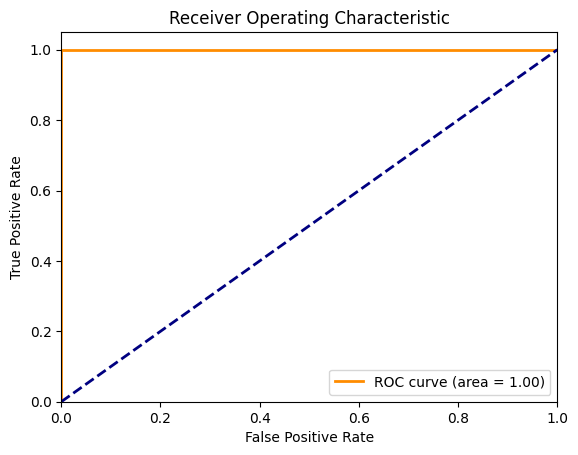

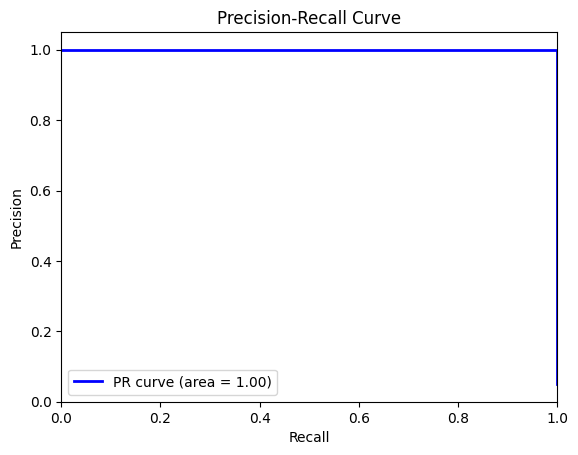

Time taken to fit the model: 207.76 seconds
Time taken to make predictions: 2.24 seconds


In [12]:
mini_r = RocketClassifier(rocket_transform="minirocket")

# Measure the time taken to fit the model
start_time_fit = time.time()
mini_r.fit(x_train, y_train)
end_time_fit = time.time()

# Measure the time taken to make predictions
start_time_predict = time.time()
y_pred = mini_r.predict(x_test)
end_time_predict = time.time()

# Calculate accuracy
accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy: {accuracy}")

# If binary classification, get probability scores for the positive class
y_proba = mini_r.predict_proba(x_test)[:, 1]

# Compute ROC curve and ROC area
fpr, tpr, _ = roc_curve(y_test, y_proba)
roc_auc = auc(fpr, tpr)
print(f"ROC AUC: {roc_auc}")

# Compute Precision-Recall curve and PR area
precision, recall, _ = precision_recall_curve(y_test, y_proba)
pr_auc = auc(recall, precision)
print(f"PR AUC: {pr_auc}")

# Plot ROC curve
plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc="lower right")
plt.show()

# Plot Precision-Recall curve
plt.figure()
plt.plot(recall, precision, color='b', lw=2, label='PR curve (area = %0.2f)' % pr_auc)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve')
plt.legend(loc="lower left")
plt.show()

# Execution times
fit_time = end_time_fit - start_time_fit
predict_time = end_time_predict - start_time_predict
print(f"Time taken to fit the model: {fit_time:.2f} seconds")
print(f"Time taken to make predictions: {predict_time:.2f} seconds")

In [13]:
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred, average='weighted')
recall = recall_score(y_test, y_pred, average='weighted')
f1 = f1_score(y_test, y_pred, average='weighted')

print(f"Accuracy: {accuracy}")
print(f"Precision: {precision}")
print(f"Recall: {recall}")
print(f"F1 Score: {f1}")

# Confusion matrix and classification report
print("Confusion Matrix:")
print(confusion_matrix(y_test, y_pred))
target_names = ['0', '1']
print("Classification Report:")
print(classification_report(y_test, y_pred, target_names=target_names))

Accuracy: 1.0
Precision: 1.0
Recall: 1.0
F1 Score: 1.0
Confusion Matrix:
[[1899    0]
 [   0  101]]
Classification Report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00      1899
           1       1.00      1.00      1.00       101

    accuracy                           1.00      2000
   macro avg       1.00      1.00      1.00      2000
weighted avg       1.00      1.00      1.00      2000



In [14]:
from aeon.classification.hybrid import HIVECOTEV1, HIVECOTEV2
hc2 = HIVECOTEV2(time_limit_in_minutes=0.2)


Accuracy: 0.9945
ROC AUC: 0.9998227310882747
PR AUC: 0.9966934069971298


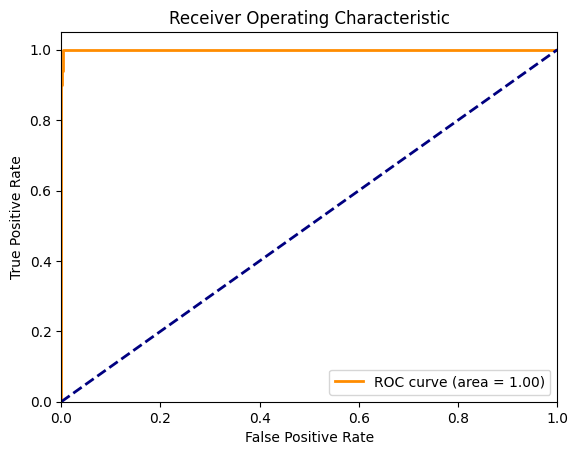

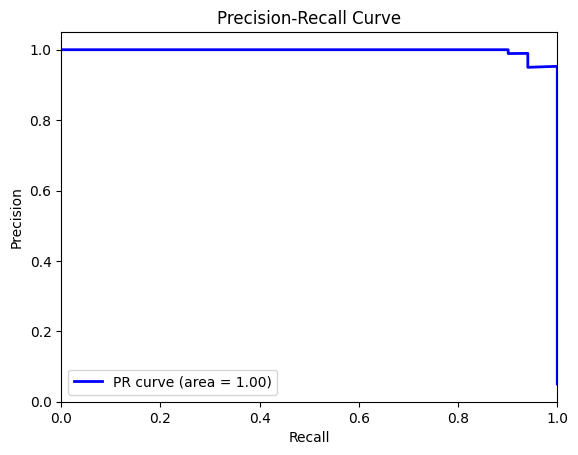

Time taken to fit the model: 3399.12 seconds
Time taken to make predictions: 33.73 seconds


In [16]:
start_time_fit = time.time()
hc2.fit(x_train, y_train)
end_time_fit = time.time()

# Measure the time taken to make predictions
start_time_predict = time.time()
y_pred = hc2.predict(x_test)
end_time_predict = time.time()

# Calculate accuracy
accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy: {accuracy}")

# If binary classification, get probability scores for the positive class
y_proba = hc2.predict_proba(x_test)[:, 1]

# Compute ROC curve and ROC area
fpr, tpr, _ = roc_curve(y_test, y_proba)
roc_auc = auc(fpr, tpr)
print(f"ROC AUC: {roc_auc}")

# Compute Precision-Recall curve and PR area
precision, recall, _ = precision_recall_curve(y_test, y_proba)
pr_auc = auc(recall, precision)
print(f"PR AUC: {pr_auc}")

# Plot ROC curve
plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc="lower right")
plt.show()

# Plot Precision-Recall curve
plt.figure()
plt.plot(recall, precision, color='b', lw=2, label='PR curve (area = %0.2f)' % pr_auc)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve')
plt.legend(loc="lower left")
plt.show()

# Execution times
fit_time = end_time_fit - start_time_fit
predict_time = end_time_predict - start_time_predict
print(f"Time taken to fit the model: {fit_time:.2f} seconds")
print(f"Time taken to make predictions: {predict_time:.2f} seconds")

In [17]:
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred, average='weighted')
recall = recall_score(y_test, y_pred, average='weighted')
f1 = f1_score(y_test, y_pred, average='weighted')

print(f"Accuracy: {accuracy}")
print(f"Precision: {precision}")
print(f"Recall: {recall}")
print(f"F1 Score: {f1}")

# Confusion matrix and classification report
print("Confusion Matrix:")
print(confusion_matrix(y_test, y_pred))
target_names = ['0', '1']
print("Classification Report:")
print(classification_report(y_test, y_pred, target_names=target_names))

Accuracy: 0.9945
Precision: 0.9945316753926702
Recall: 0.9945
F1 Score: 0.9943495647536353
Confusion Matrix:
[[1899    0]
 [  11   90]]
Classification Report:
              precision    recall  f1-score   support

           0       0.99      1.00      1.00      1899
           1       1.00      0.89      0.94       101

    accuracy                           0.99      2000
   macro avg       1.00      0.95      0.97      2000
weighted avg       0.99      0.99      0.99      2000

